4.1 Sesssion overview

This is a further clarrification and work related to the churn prediction.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data_churm_project.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [ ]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter= len(X_train)*10)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,42250
,multi_class,'deprecated'


In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

4.2 Accuracy and dummy model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [ ]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


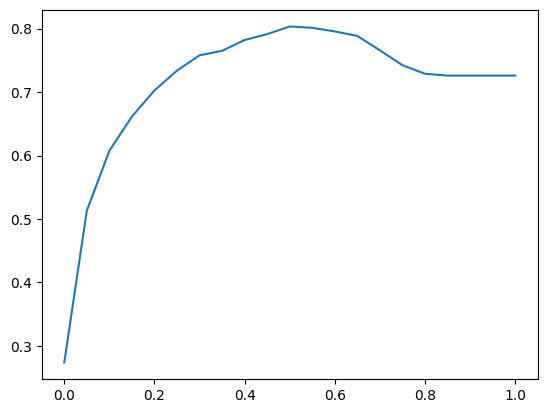

In [ ]:
plt.plot(thresholds, scores)

In [13]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [14]:
y_val.mean()

np.float64(0.2739531582682754)

For the last two cells, there is no churn prediction that have the value of 1.

But if we evaluate the churn for the validation dataset, 27% of the values are 1. There is a class inbalance in the churn values.

4.3 Confusion Matrix

The goal is to dive into the diferent errors that your binary classifcation did.

True_Positive; Fasle_Positive; True_Negative; Fasle_Negative.

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

#TN;FP
#FN;TP

array([[920, 103],
       [174, 212]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

4.4 Precision and Recall

In [20]:
p = tp / (tp + fp)
print(p)
print(1-p)

0.6730158730158731
0.32698412698412693


32% of customer are not likely to churn but we din'd find them.

In [21]:
r = tp / (tp + fn)
print(r)
print(1-r)

0.5492227979274611
0.4507772020725389


45% of customer that are not churning is considered as churning. So they will profite our promotion.

4.5 ROC Curves

In [22]:
tpr = tp / (tp + fn)
print(tpr)

fpr = fp / (fp + tn)
print(fpr)

0.5492227979274611
0.10068426197458455


In [23]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

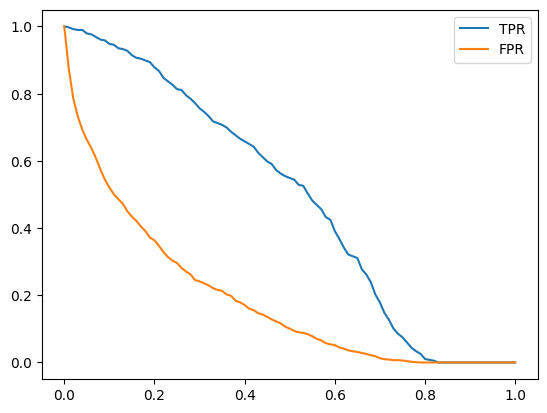

In [ ]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

Random model

In [25]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [26]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

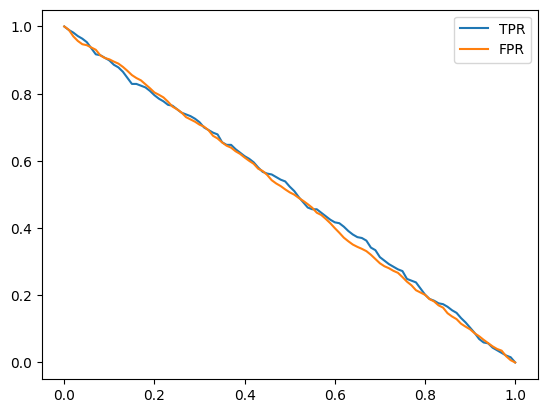

In [ ]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Ideal model

In [28]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
print(num_neg, num_pos)

y_ideal = np.repeat([0, 1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))
1 - y_val.mean()

1023 386


np.float64(0.7260468417317246)

In [29]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

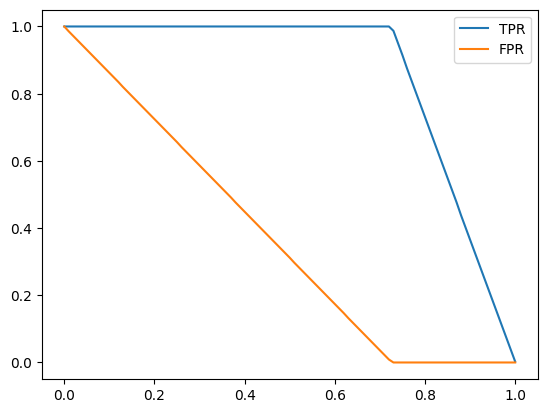

In [30]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

Putting everything together


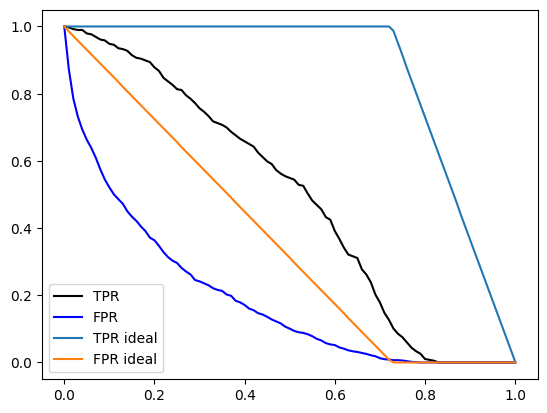

In [31]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

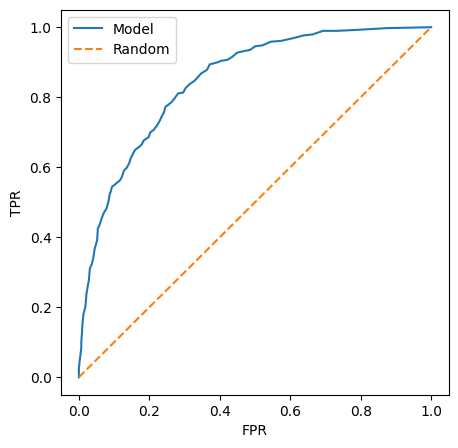

In [32]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

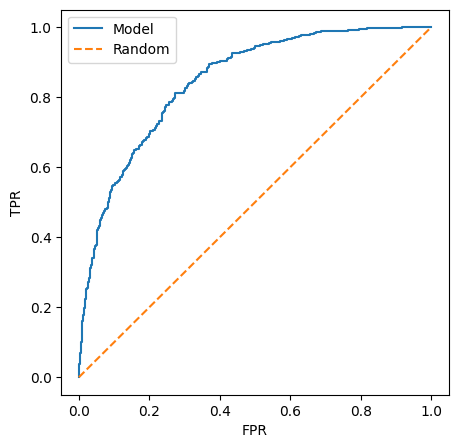

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


4.6 Area under the ROC or ROC AUC

AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.

In [34]:
from sklearn.metrics import auc

In [35]:
auc(fpr,tpr)

0.8463120254863528

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val,y_pred)

0.8463120254863528

4.7 Crossv-Validation

In [49]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=len(df_train)*10)
    model.fit(X_train, y_train)
    
    return dv, model

In [50]:
dv, model = train(df_train, y_train, C=0.001)

In [51]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
    
y_pred = predict(df_val, dv, model)

In [47]:
from sklearn.model_selection import KFold

In [41]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [42]:
from tqdm.auto import tqdm

In [52]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:02<00:14,  2.41s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:06<00:16,  3.26s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:13<00:20,  5.11s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:18<00:15,  5.03s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:23<00:10,  5.06s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:28<00:05,  5.08s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [00:33<00:00,  4.79s/it]

C=10 0.842 +- 0.007


In [53]:
scores

[0.8439646442841331,
 0.8448115315852205,
 0.833694561509131,
 0.8348128637206625,
 0.8516441278905589]

In [54]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997